# Tutorial 7: Plotting and selecting data from netCDF

This tutorial will continue working with netCDF files in Xarray and we'll move beyond the basics. In the previous tutorial, we looked at the entire area of the netCDF file. But, as scientists, we often have a specific region of interest that is a subset of the larger dataset region. In this tutorial, we'll learn how to select and plot only an area of interest to us. 

By the end of this tutorial, you will be able to:
* align a cartopy region with netCDF data
* create a map using continuous or gridded data from netCDF
* select a point and a region of interest from the entire dataset

<font color=red>**Note:**</font> This tutorial uses the cmoceans packages, which is a library of very nice colormaps for plotting. You can check out more info here https://matplotlib.org/cmocean/#. 
Before moving forward, you must install cmoceans. To do this, open a new terminal (Mac) or Anaconda Prompt (PC) window, and type in `conda install -c conda-forge cmocean`. Hit enter, and when prompted type `y`. Then continue with this tutorial!

In [3]:
# for data manipulation and opening files
import xarray as xr
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
from cartopy import crs, feature
import numpy as np
import cmocean

### Downloading data

Files of large gridded datasets can be too large to easily share. Instead, you will need to download the data yourself. In later tutorials, we will show ways to download data with Python code and ways to work with cloud-based data without downloading. 

**Note:** Satellite data available online can be found at different levels of processing. For this tutorial, we will be working with L3, or level 3, satellite data. This means the data is spaced evenly on a uniform grid, and the time steps are uniform as well.  When searching for data, be sure to specify L3 in the search bar.

1. Go to https://worldview.earthdata.nasa.gov/. 
2. Play around with the different data available. There are many different satellite data products. For this tutorial, we will be using Aqua MODIS Global Mapped Chlorophyll-a. The code examples will be specific to this data, but you can choose any data product and just change the variable names.    
3. Once you have selected a data product and date, click "Data" in the top left corner then click on "NASA's Earthdata Search". Or go to https://search.earthdata.nasa.gov/. 
4. In the EarthData search, you will need to fill in the "Search for collections or topics" bar at the upper left corner. Include information such as the instrument (Aqua), the data product (chlorophyll), and the level (L3). Hit enter.
    - **Reminder:** Even if you choose to work with a different data product, be sure to select L3 data, not L2. 
5. In the center white panel, a list of types of satellite data products will appear. Scroll through to find the product that matches what you want. The data in this tutorial can be found under the "Aqua MODIS Global Mapped Chlorophyll (CHL) Data, version 2018" list item. Click the data product you want. 
6. A series of boxes for each data file will appear. In the case of the Aqua Chlorophyll-a product, each box is one day of data mapped globally. There are two different grid scales to choose from for each day: 4 km and 9 km grids. The 4 km grid is used in this tutorial. Once you find a date of interest and an appropriate grid size, click the download icon in the bottom lefthand corner of the data box (not the large download buttom in the bottom right corner).
7. You will be directed to register an account with NASA Earthdata. Follow the instructions to create an account. 
8. Once you've created an account and logged in, your file will automatically download.
9. Your file might download as a .zip if it is especially large. In that case, click the file to unzip and then change the file names in the tutorial to include the path.

A note on the naming convention: the Aqua chlorophyll files start with "A#######". The A stands for Aqua (the satellite), and the numbers are YYYYDDD. The first four numbers are the year, and the last three numbers are the date of the year starting at 1 and going to 365. So the date of the below file is day 185 of 2022, or July 4.

In [1]:
# change this file name and/or path if you are using different data
file = 'A2022185.L3m_DAY_CHL_chlor_a_4km.nc'

In [4]:
# use xarray to open the file you chose
data = xr.open_dataset(file,engine='netcdf4')

In [5]:
# what does this data look like?
data

<xarray.Dataset>
Dimensions:  (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (lat, lon) float32 ...
    palette  (rgb, eightbitcolor) uint8 ...
Attributes: (12/63)
    product_name:                      A2022185.L3m_DAY_CHL_chlor_a_4km.nc
    instrument:                        MODIS
    title:                             MODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    temporal_range:                    day
    ...                                ...
    identifier_product_doi:            10.5067/AQUA/MODIS/L3M/CHL/2018
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         2113263
    data_minimum:                      0.0087185865
    data_maximum:                      99.204636

### Plotting the entire area

When we first open data, it can sometimes be useful to plot the entire area. This may give us an idea of what the data looks like or any areas of interest.

In [6]:
# the data of interest
chlor = data['chlor_a']

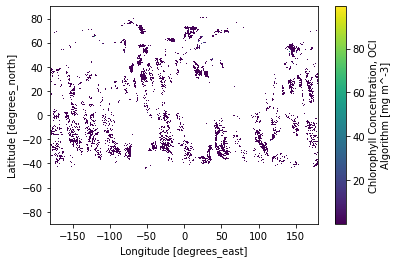

In [7]:
# xarray has a built-in interface with matplotlib plotting libraries
chlor.plot()
plt.show()

This is a pretty bad figure, but we can get some basic information from it. First, everything seems really patchy. Why is that?

**Knowledge Check:** Why are there so many empty spaces in the figure above? What does this have to do with how satellites collect data and with the type of data we are using?

The data we are using comes from the Aqua polar-orbiting satellite. Polar orbiting satellites produce data in swaths, or stripes across the globe. That is why the purple areas on our map look like broken-up stripes. The instrument that is collecting the data, MODIS, is collecting visible reflectance data to measure chlorophyll. This means that there is only data in areas where the instrument can get reflected light from the surface. The date of the data is during northern hemisphere summer, which means southern hemisphere winter. During the winter, the poles receive little to no sunlight, so there is minimal reflectance that can occur. Finally, some of the blank areas in the middle of the map happen because of land masses! We are looking at a processed chlorophyll-a data product, which means that someone has created a program to only look at chlorophyll-a over the water, not on land. Can you identify any landmasses in the map?

### Selecting areas on a map

Now that we've looked at the entire dataset area, we can zoom in on a particular section. There are a few ways to do this, but we'll practice the easiest first.

The easiest method to zoom into an area on a map is to only plot that area with cartopy. This is fast and useful for making a map for presentations, but there are some downsides.   
* First, this method does not remove the rest of the data, it just hides it from our view. If you wanted to find the average chlorophyll-a concentration in the zoomed in area, you could not calculate it from the map because the rest of the data actually still exists.    
* Second, outliers in the data outside the zoomed in area might affect the colorbar scale of the displayed map. So you could have a map area with concentrations all below 20 mg/m$^{3}$, but a larger concentration elsewhere in the dataset will skew the colorbar scale and you won't be able to see the low concentrations clearly.   
* Finally, for really big datasets, it might take a while to plot. You're still technically plotting all the data, it just isn't displayed in the figure area. So if the dataset is really big, you're wasting time plotting data that you don't actually see. 

In [ ]:
# use a specialty colormap for algae
cmap = cmocean.cm.algae

In [ ]:
# select lat and lon region of interest
# use the map created above to start zooming in on an area that has a lot of purple coverage
# the area of purple coverage might be different than the lats and lons here if you chose a different date
latmin = 37
latmax = 45
lonmin = -65
lonmax = -75

In [ ]:
# set the extents of our box
extent = [lonmin,lonmax,latmin,latmax]

In [ ]:
# select map projection - do you remember what this is for this dataset?
proj = crs.PlateCarree()

In [ ]:
# in order to plot a subset of the data on the map, we must make a grid of the coordinates
# first, get a list of each coordinate
lats = chlor['lat']
lons = chlor['lon']

# then make a grid
XX,YY = np.meshgrid(lons,lats)

In [ ]:
# create a pyplot figure
fig = plt.figure(figsize=(8,10))
# create a new axes instance with the map information
ax = fig.add_subplot(1,1,1,projection=proj)
ax.set_extent(extent)
# add gridlines
gl = ax.gridlines(crs.PlateCarree(),draw_labels=True,linewidth=1,color='gray',alpha=0.5,linestyle='--')
# add features
ax.add_feature(feature.STATES)
ax.add_feature(feature.RIVERS)
im = plt.contourf(XX,YY,chlor,cmap=cmap,transform=proj)
plt.colorbar(im,orientation='horizontal',label='Chlorophyll-a concentration (mg/m$^{3}$)')
plt.show()

What do you notice about this figure? What about the colorbar scale? What could make this figure better?

The figure above has a colorbar scale that goes from 0 to 105 mg/m$^{3}$, even though the data in the figure does not seem to go this high. This is one of the problems with this plotting method. Your colorbar scale may be different if you used a different date of data.

Instead of plotting all the data but hiding most of it, we can instead select a subsection of the data using slicing. This method takes a few more steps because you need to know the area of interest. However, there are several benefits such as being able to really focus on the actual area of interest. 

In [ ]:
# identify the map area extent
latmin = 37
latmax = 45
lonmin = -65
lonmax = -75

In [ ]:
# slice the data using these limits
subset = chlor.sel(lat=slice(latmax,latmin),lon=slice(lonmax,lonmin))

In [ ]:
# check out the data and the change in dimensions
subset

In [ ]:
# set the extents of our box
extent = [lonmin,lonmax,latmin,latmax]
# select map projection
proj = crs.PlateCarree()

In [ ]:
# in order to plot a subset of the data on the map, we must make a grid of the coordinates
# first, get a list of each coordinate
lats = subset['lat']
lons = subset['lon']

# then make a grid
XX,YY = np.meshgrid(lons,lats)

In [ ]:
# create a pyplot figure
fig = plt.figure(figsize=(8,10))
# create a new axes instance with the map information
ax = fig.add_subplot(1,1,1,projection=proj)
ax.set_extent(extent)
# add gridlines
gl = ax.gridlines(crs.PlateCarree(),draw_labels=True,linewidth=1,color='gray',alpha=0.5,linestyle='--')
# add features
ax.add_feature(feature.STATES)
ax.add_feature(feature.RIVERS)
im = plt.contourf(XX,YY,subset,cmap=cmap,transform=proj)
plt.colorbar(im,orientation='horizontal',label='Chlorophyll-a concentration (mg/m$^{3}$)')
plt.show()

The colorbar scale on this figure is a little better, and the code cell also ran a lot faster. However, this is still not great. Let's try changing the colorbar a little to make the figure more appealing.

Before modifying the colorbar or the data, let's first analyze this subset of data to figure out the range (min and max) that we're working with.

In [ ]:
subset.min()

In [ ]:
subset.max()

**Knowledge Check:** Based on the two code cells above, and your experience with pandas, how would you find the mean of the subset data?

In [ ]:
# mean of subset


To find the mean, use `subset.mean()`.

The range 0.04 mg/m$^{3}$ to 86 mg/m$^{3}$ is really large. One possibility to plot this data better is to use a log scale on the colorbar, rather than a linear scale. Again, your range may vary if you selected a different date of data to work with. 

In [ ]:
# to make a log scale, we change the normalization, or norm, of the colorbar scale
import matplotlib.colors as colors
norm = colors.LogNorm(vmin=subset.min(), vmax=subset.max())

In [ ]:
# create a pyplot figure
fig = plt.figure(figsize=(8,10))
# create a new axes instance with the map information
ax = fig.add_subplot(1,1,1,projection=proj)
ax.set_extent(extent)
# add gridlines
gl = ax.gridlines(crs.PlateCarree(),draw_labels=True,linewidth=1,color='gray',alpha=0.5,linestyle='--')
# add features
ax.add_feature(feature.STATES)
ax.add_feature(feature.RIVERS)
im = plt.contourf(XX,YY,subset,cmap=cmap,norm=norm,transform=proj)
plt.colorbar(im,orientation='horizontal',label='Chlorophyll-a concentration (mg/m$^{3}$)')
plt.show()

This figure is somewhat better. It is possible to distinguish between different regions of chlorophyll concentrations, but it is hard to tell the concentrations apart within those big chunks. What do you notice about the spatial distribution of the areas with high concentration compared to the areas with low concentration? In other words, which areas on the map tend to have the darkest color, and which areas tend to have the lightest color? 

The real issue with the data we are plotting is that we are trying to plot two different types of algae regions on one figure: the open ocean which has lower concentrationss and the coastal areas which have much higher concentrations. What we really need to do is focus in on one or the other.

In order to focus our data a little better, we can set limits of Chlorophyll-a concentration, where above the limit means coastal area and below the concentration means open ocean. Based on the figure above, what do you think could be the cut-off limits?

In [ ]:
# set a cut-off limit here
cut_off = 2

In [ ]:
coastal = subset.where(subset>=cut_off)
ocean = subset.where(subset<cut_off)

In [ ]:
# create a pyplot figure
fig = plt.figure(figsize=(8,10))
# create a new axes instance with the map information
ax = fig.add_subplot(1,1,1,projection=proj)
ax.set_extent(extent)
# add gridlines
gl = ax.gridlines(crs.PlateCarree(),draw_labels=True,linewidth=1,color='gray',alpha=0.5,linestyle='--')
# add features
ax.add_feature(feature.STATES)
ax.add_feature(feature.RIVERS)
im = plt.contourf(XX,YY,ocean,cmap=cmap,transform=proj)
plt.colorbar(im,orientation='horizontal',label='Chlorophyll-a concentration (mg/m$^{3}$)')
plt.show()

Play around with the cut-off value. You'll notice that the area and colorbar of the ocean data changes as you change the cut-off value. What do you think will happen with the coastal region?

### Exercises

**1.** Make a figure of the coastal region from the data above! This problem will walk you through several steps.   
a) Plot the data for the coastal region using a cut-off you select.

b) Based on your plot, where is the important coastal data located? Zoom in on this area by creating new lat and lon extents and subselecting the coastal data.

In [ ]:
latmin =
latmax =
lonmin =
lonmax =

In [ ]:
coastal_subset = 

c) Plot this new data.

**2.** Download a different type of data from NASA EarthData. Remember to use L3 data! Any single day of data will work. Select the variable of interest. Create a global map of the data using `var.plot()`.   

**3.** Using the new data that you downloaded in question 2, zoom in on a region of interest to use and plot this region with a cartopy map background. Find the minimum, maximum, and mean of the data in this zoomed-in region. 

### Possible Solutions

In [ ]:
# 1a
cut_off = 5
coastal = subset.where(subset>=cut_off)
ocean = subset.where(subset<cut_off)

latmin = 37
latmax = 45
lonmin = -65
lonmax = -75
extent = [lonmin,lonmax,latmin,latmax]
# get the lat lon grid
XX,YY = np.meshgrid(coastal['lon'],coastal['lat'])

fig = plt.figure(figsize=(8,10))
# create a new axes instance with the map information
ax = fig.add_subplot(1,1,1,projection=proj)
ax.set_extent(extent)
# add gridlines
gl = ax.gridlines(crs.PlateCarree(),draw_labels=True,linewidth=1,color='gray',alpha=0.5,linestyle='--')
# add features
ax.add_feature(feature.STATES)
ax.add_feature(feature.RIVERS)
im = plt.contourf(XX,YY,coastal,cmap=cmap,transform=proj)
plt.colorbar(im,orientation='horizontal',label='Chlorophyll-a concentration (mg/m$^{3}$)')
plt.show()

In [ ]:
# 1b
latmin = 40
latmax = 42
lonmin = -72
lonmax = -74.5
coastal_subset = coastal.sel(lat=slice(latmax,latmin),lon=slice(lonmax,lonmin))

In [ ]:
coastal_subset

In [ ]:
# 1c
# set the extents of our box
extent = [lonmin,lonmax,latmin,latmax]
# select map projection
proj = crs.PlateCarree()
# get the lat lon grid
XX,YY = np.meshgrid(coastal_subset['lon'],coastal_subset['lat'])

fig = plt.figure(figsize=(8,10))
# create a new axes instance with the map information
ax = fig.add_subplot(1,1,1,projection=proj)
ax.set_extent(extent)
# add gridlines
gl = ax.gridlines(crs.PlateCarree(),draw_labels=True,linewidth=1,color='gray',alpha=0.5,linestyle='--')
# add features
ax.add_feature(feature.STATES)
ax.add_feature(feature.RIVERS)
im = plt.contourf(XX,YY,coastal_subset,cmap=cmap,transform=proj)
plt.colorbar(im,orientation='horizontal',label='Chlorophyll-a concentration (mg/m$^{3}$)')
plt.show()